In [2]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import geopandas as gpd 
from geopandas import GeoSeries

from shapely.geometry import Point

from convertbng.util import convert_bng, convert_lonlat

import gif

%matplotlib inline

### Load Files

In [2]:
# TODO (1) put this info in East North csv
df_original = pd.read_csv("../capstone_train/train.csv")

# load police area map
# https://geoportal.statistics.gov.uk/datasets/police-force-areas-december-2017-ew-bfc
police_area_map = gpd.read_file("../capstone_train/police_map/Police_Force_Areas__December_2017__Boundaries.shp")

# Load converted coordenates
df_coor = pd.read_csv("../capstone_train/clusters/east_north_coor.csv")

### Plot complete search operations map

In [7]:
# df_clean_path = '../capstone_train/df_clean.csv'
# df_clean = pd.read_csv(df_clean_path, index_col=0)

In [5]:
# street_map = gpd.read_file("../capstone_train/police_map/GBR_roads.shp")

# geometry = [Point(xy) for xy in zip(df_clean["Longitude"], df_clean["Latitude"])]
# geo_df = gpd.GeoDataFrame(df_clean, crs = street_map.crs, geometry = geometry)

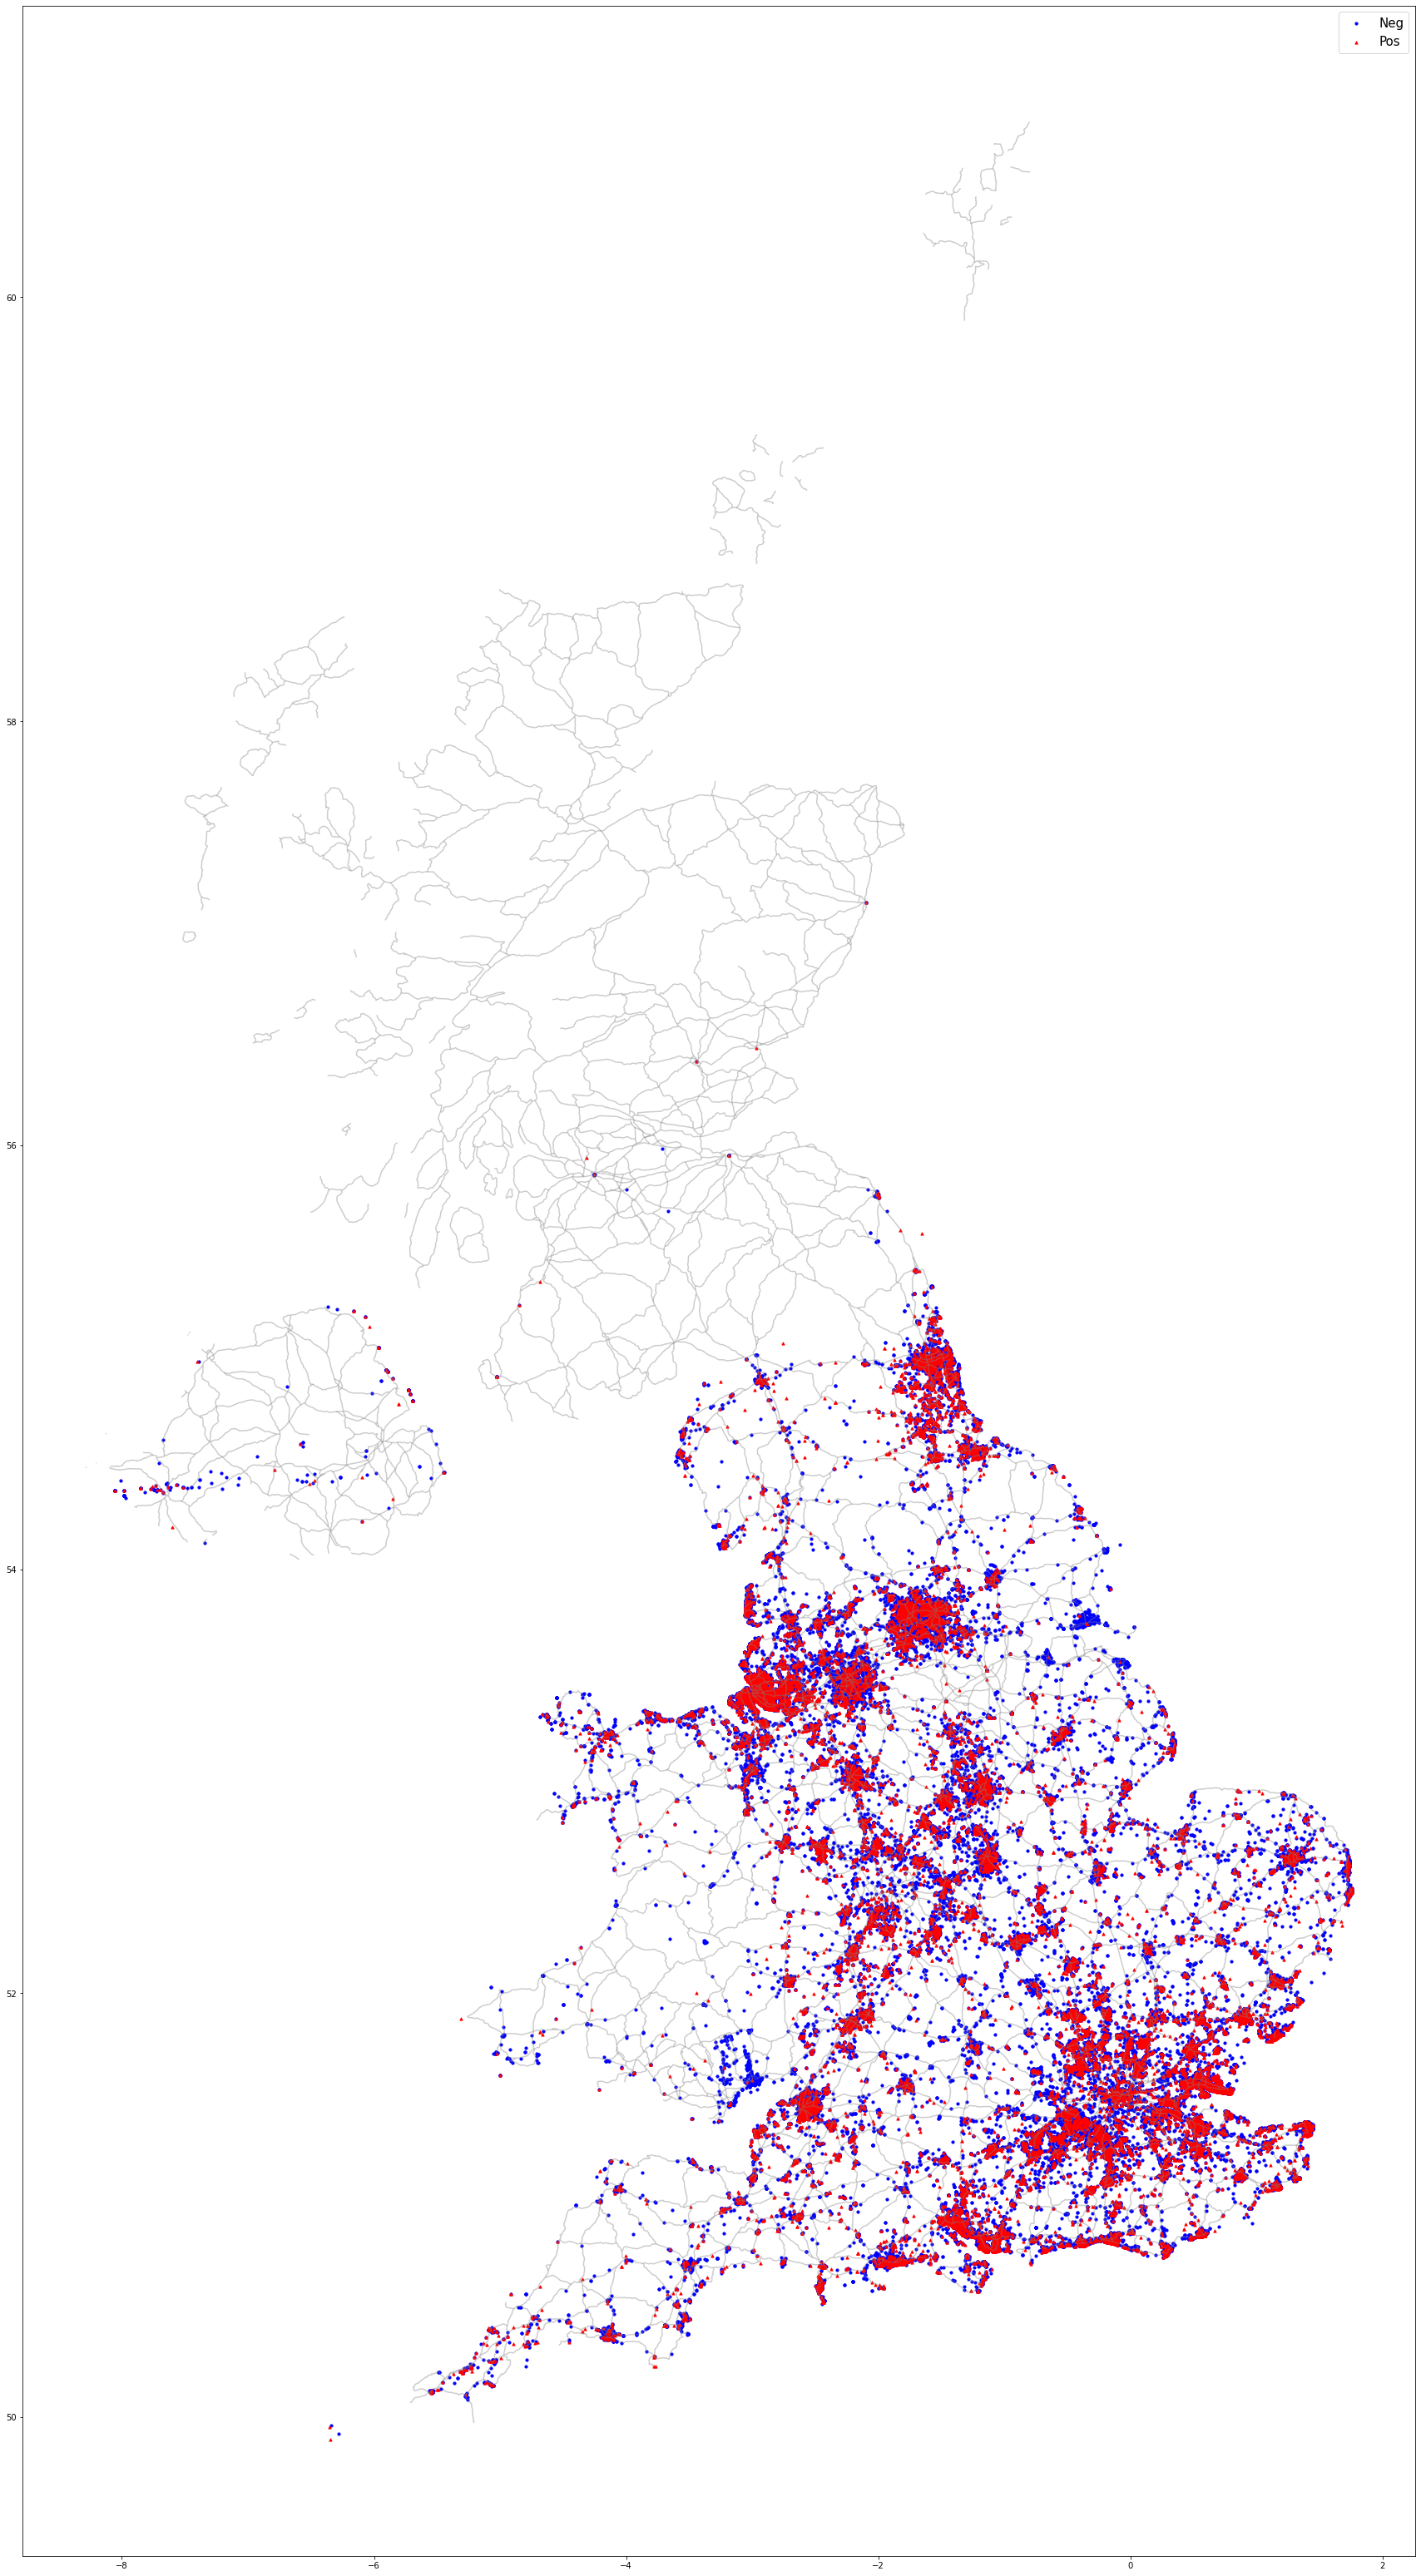

In [6]:
# fig, ax = plt.subplots(figsize = (30, 60))
# street_map.plot(ax = ax, alpha = 0.4, color = "grey")
# geo_df[geo_df['target'] == 0].plot(ax = ax, markersize = 10, color = "blue", marker = 'o', label = 'Neg')
# geo_df[geo_df['target'] == 1].plot(ax = ax, markersize = 10, color = "red", marker = '^', label = 'Pos')
# plt.legend(prop = {'size': 15})

In [ ]:
# raise SystemExit("Stop")

### Pre Process

In [3]:
def clean_df_coor(df_coor):
    #converto to numeric
    df_coor_clean = df_coor.apply(pd.to_numeric).copy()
    
    # remove extreme outliners
    df_coor_clean = df_coor_clean[(df_coor_clean.quantile(0.0001) < df_coor_clean) & 
                                  (df_coor_clean < df_coor_clean.quantile(0.9999))]
    df_coor_clean = df_coor_clean.dropna(how='any')
    
    return df_coor_clean

df_coor_clean = clean_df_coor(df_coor)

In [4]:
# create geometry column with Point values and remove Metropolitan station data
def create_df_geometry(df_coor_clean, df_original, police_area_map):
    
    geometry = [Point(xy) for xy in zip(df_coor_clean["Easting"], df_coor_clean["Northing"])]
    df_geo = gpd.GeoDataFrame(df_coor_clean, crs=police_area_map.crs, geometry = geometry)

    # desnecessário depois do TODO (1)
    # join dfs
    df_geo_stations = pd.concat([df_geo, df_original[['station', 'Latitude', 'Longitude']]], axis=1,  join='inner')
    # remove Metropolitan
    df_geo_clean = df_geo_stations[~(df_geo_stations.station == 'metropolitan')]    
    
    return df_geo_clean

df_geo_stations = create_df_geometry(df_coor_clean, df_original, police_area_map)

In [5]:
# Format station name
def beautify_station_name(station):
    station_spaced = station.replace('-',' ')
    capitalized_parts = station_spaced.split(" ")
    capitalized_parts[0] = capitalized_parts[0].capitalize()
    capitalized_parts[-1] = capitalized_parts[-1].capitalize()
    station_name_clean = " ".join(capitalized_parts)
    
    return station_name_clean

In [6]:
# plots to find optimal k for each station
def calculate_plot_optimal_k_station(df_geo_stations, first_k, last_k, save_path):
    
    def save_and_plot_elbow_and_silhouette(ssd, sil, station, first_k, last_k, save_path):
        
        station_name_clean = beautify_station_name(station)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3), constrained_layout=True)
        fig.suptitle(station_name_clean, fontsize=16)

        ax1.plot(range(first_k, last_k), sil)
        ax1.set_xlabel('k')
        ax1.set_ylabel('Sum of Squared Distances')
        ax1.set_title('Silhouette Method')

        ax2.plot(range(first_k, last_k), ssd)
        ax2.set_xlabel('k')
        ax2.set_ylabel('Euclian Distances')
        ax2.set_title('Elbow Method')

        plt.savefig(f'{save_path}/{station}_optimal_k.png')
    
    
    for station in df_geo_stations.station.unique():

        geo_df_sta = df_geo_stations.loc[df_geo_stations['station'] == station].copy()
        x = geo_df_sta[["Easting","Northing"]]

        sil = []
        ssd = []
        for i in range(first_k, last_k):
            # Find clusters
            km = MiniBatchKMeans(n_clusters=i)
            km.fit_predict(x)

            # Save images form Silhouette and Elbow Method to find the optimal K for each station
            ssd.append(km.inertia_)
            sil.append(silhouette_score(x, km.labels_, metric = 'euclidean'))

        save_and_plot_elbow_and_silhouette(ssd, sil, station, first_k, last_k, save_path)
        
save_path = '../capstone_train/clusters/optimal_pngs'
first_k, last_k = 3, 20
#calculate_plot_optimal_k_station(df_geo_stations, first_k, last_k, save_path)

In [7]:
#Get optimal K for each station after calculated with calculate_plot_optimal_k_station(..)
station_optimal_k_png_folder = '../capstone_train/clusters/optimal_pngs/optimal_labelled'
optimal_methods_png_tag = '_optimal_'

def get_optimal_k_each_station_dict():
    station_optimal_k = {}
    
    station_k_pngs = os.listdir(station_optimal_k_png_folder)
    for png_name in station_k_pngs:
        if optimal_methods_png_tag in png_name:
            station, optimal_k = png_name.split(optimal_methods_png_tag)
            station_optimal_k[station] = optimal_k[:-4]

    return station_optimal_k

optimal_k_station_dict = get_optimal_k_each_station_dict()

In [14]:
print(dict(list(optimal_k_station_dict.items())[0: 5]))

{'durham': '13', 'gloucestershire': '11', 'city-of-london': '12', 'greater-manchester': '6', 'cheshire': '9'}


In [8]:
# ceate cluster column for each station
def create_df_cluster_and_k_centers_list(geo_df_station, optimal_k_station_dict, calc_otimal_k=False):
    # n_labels = 0
    df_station_clusters_list = []
    station_k_centers = {}
    
    df_cluster_to_save = pd.DataFrame(index=geo_df_station.index)
    df_cluster_to_save['cluster'] = ''

    for station, optimal_k in optimal_k_station_dict.items():

        geo_df_sta = geo_df_station.loc[geo_df_station['station'] == station].copy()
        
        # Clusters classifier
        km = MiniBatchKMeans(n_clusters=int(optimal_k), random_state=42)
        
        #
        # TODO: Improve in the future
        # trained on East/North for plot and 
        # on Lat/Long to save classifier and be able predict new values with no need of conversion
        #
        
        
        # TO classifie new points
        # since the clusters might have different namming, we need to train the search model with this clusters
        x = geo_df_sta[["Latitude","Longitude"]]
        km.fit(x) 
        # save KMeans classifer of each station to predict cluster for the new point
        with open(f'../capstone_train/clusters/station_kmeans/km-{station}.pickle', 'wb') as fh:
            pickle.dump(km, fh)

        # Give different ids to each clusters in each station
        # n_labels += len(np.unique(km.labels_)) # for numerical feature
        df_cluster_to_save.loc[geo_df_sta.index,'cluster'] = km.labels_
        df_cluster_to_save.loc[geo_df_sta.index,'cluster'] = station + df_cluster_to_save['cluster'].astype(str) # for categorical feature
        
        
        # TO plot
        x = geo_df_sta[["Easting","Northing"]]
        km.fit_predict(x)

        # Label cluster centers
        centers = km.cluster_centers_
        
        # store otimal_k and centers of each station to plot the clusters later
        station_k_centers.setdefault(station, []).append(optimal_k)
        station_k_centers.setdefault(station, []).append(centers)

        # Get cluster center
        geo_df_sta['cluster'] = km.labels_
        geo_df_sta['cluster'] = station + geo_df_sta['cluster'].astype(str) # for categorical feature

        # add each station dataframe with cluster column to a list
        df_station_clusters_list.append(geo_df_sta)
        
    # join all station clusters df
    df_with_clusters_column = pd.concat(df_station_clusters_list)
    
    # save clusters for search model feature 
    df_clusters_path = '../capstone_train/clusters/df_clusters_for_model.csv'
    df_cluster_to_save.to_csv(df_clusters_path, index=True)
    
    return df_with_clusters_column, station_k_centers
    
df_clusters_plot, station_k_centers = create_df_cluster_and_k_centers_list(df_geo_stations, optimal_k_station_dict)

### Save or load df cluster to plot

In [9]:
# df_clusters_path = '../capstone_train/clusters/df_clusters_plot.csv'
# save
# df_clusters_plot.to_csv(df_clusters_path, index=True)
# load
# df_clusters_plot = pd.read_csv(df_clusters_path, index_col=0)

# need to transform dataframe in geodataframe if loaded for file
# geometry = [Point(xy) for xy in zip(df_clusters_plot["Easting"], df_clusters_plot["Northing"])]
# df_clusters_plot = gpd.GeoDataFrame(df_clusters_plot, crs=police_area_map.crs, geometry = geometry)

In [12]:
df_clusters_plot.head()

,Easting,Northing,geometry,station,Latitude,Longitude,cluster
6315,426041.584,516015.751,POINT (426041.584 516015.751),durham,54.538755,-1.599037,durham2
6316,426041.584,516015.751,POINT (426041.584 516015.751),durham,54.538755,-1.599037,durham2
6317,412809.685,538432.060,POINT (412809.685 538432.060),durham,54.740704,-1.802569,durham11
6318,428968.602,515594.797,POINT (428968.602 515594.797),durham,54.534814,-1.553841,durham2
6319,428968.602,515594.797,POINT (428968.602 515594.797),durham,54.534814,-1.553841,durham2


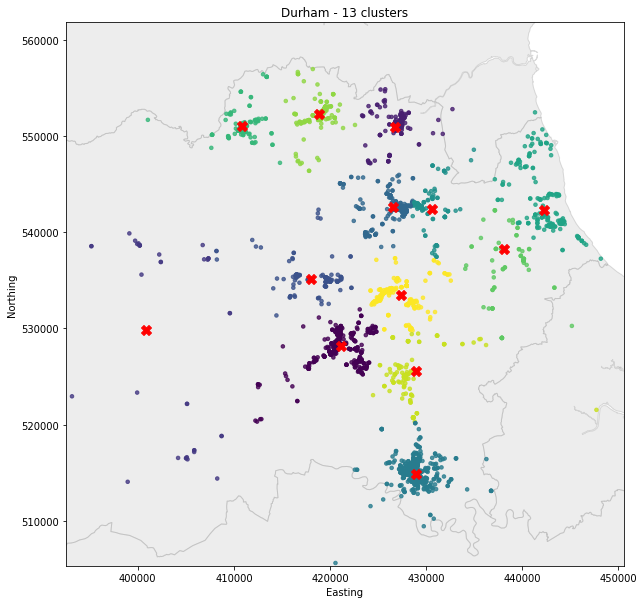

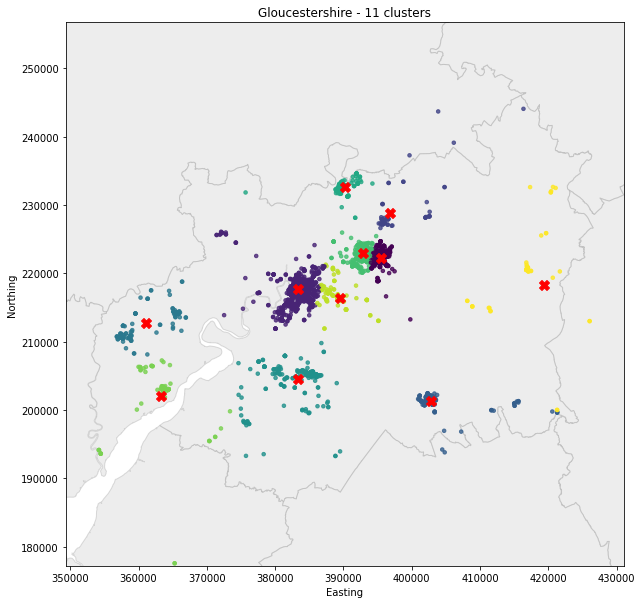

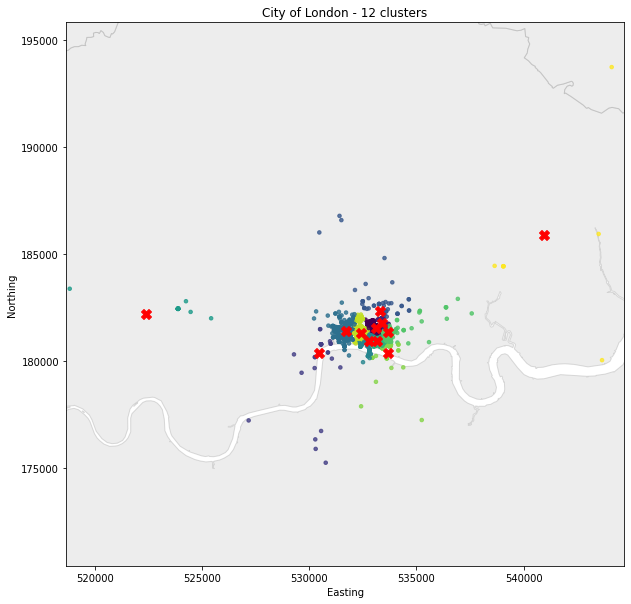

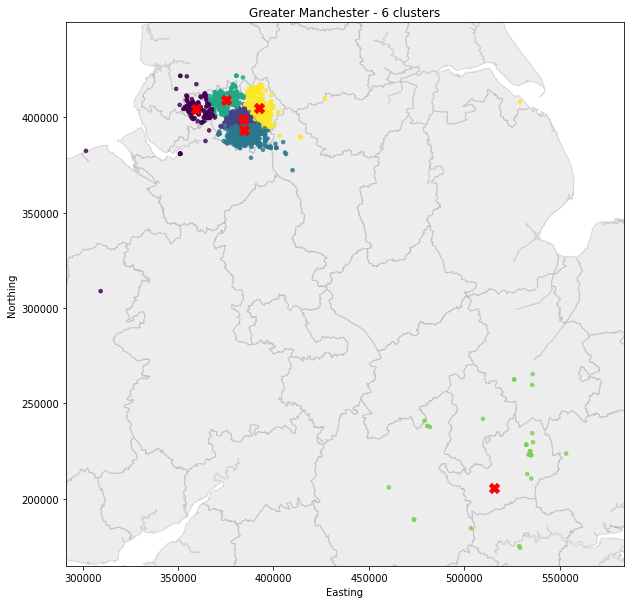

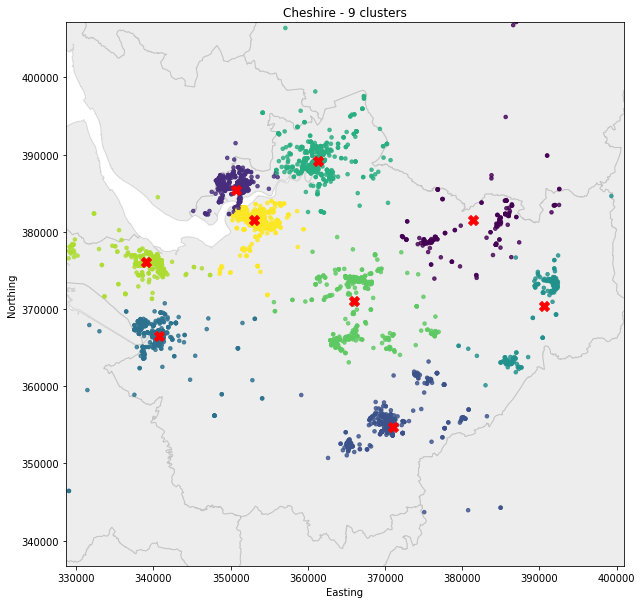

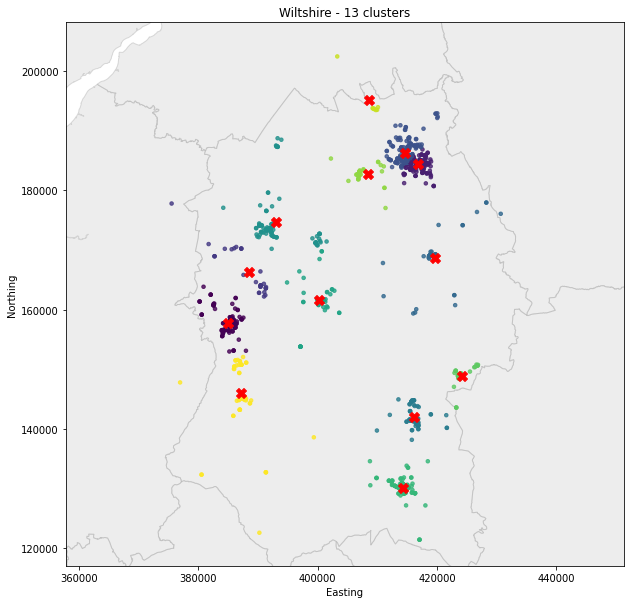

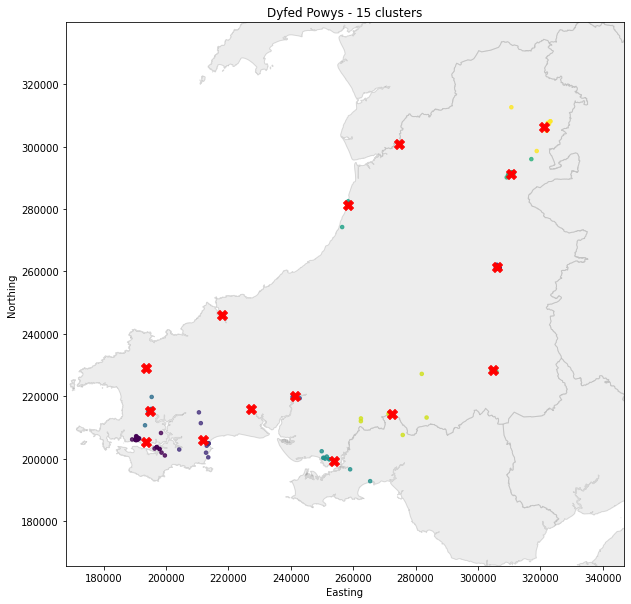

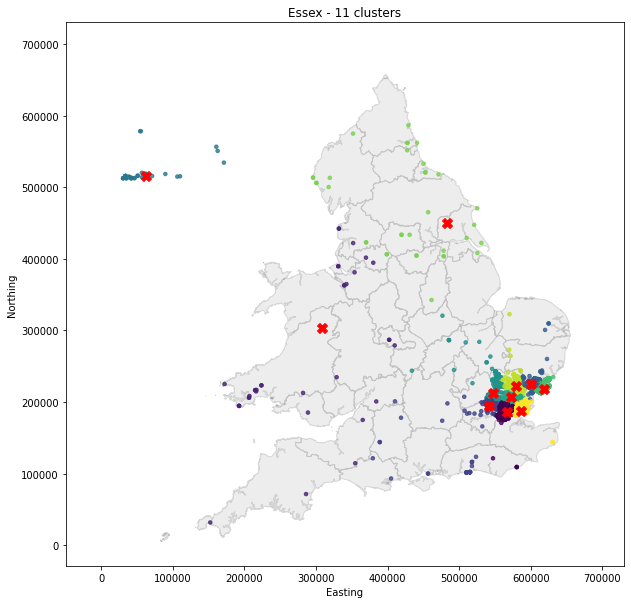

KeyboardInterrupt: 

In [11]:
# plot clusters for each station in map
def plot_station_otimal_clusters_map(df_clusters, station_k_centers, save_path, optimal_k_station_dict):
    
    def plot_geolocation_by_cluster(df_clusters_station, police_area_map, centers, title, filename):
    
        # Set figure size
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_aspect(1, "datalim")

        # plot map
        police_area_map.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)
        
        # plot coordinate points
        df_clusters_station.plot(ax=ax, column='cluster', alpha=0.8, cmap='viridis', marker=".", markersize=50, zorder=2)

        # plot cluster centers
        centers_gseries = GeoSeries(map(Point, zip(centers[:,0], centers[:,1])))
        centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)

        # frame the plot near center point boundaries
        x_min = centers[:,0].min() # df_clusters_station['Easting'].min()
        x_max = centers[:,0].max() # df_clusters_station['Easting'].max()
        y_min = centers[:,1].min() # df_clusters_station['Northing'].min()
        y_max = centers[:,1].max() # df_clusters_station['Northing'].max()
        margin_x = (x_max-x_min)/5
        margin_y = (y_max-y_min)/5
                  
        plt.axis([x_min-margin_x, x_max+margin_x, y_min-margin_y, y_max+margin_y])
        plt.title(title)
        plt.xlabel('Easting')
        plt.ylabel('Northing')
        plt.show()

        #fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)   
        fig.clf()
    #
    #
    #
    
    for station, k_center_pair in station_k_centers.items():
        optimal_k = k_center_pair[0]
        centers = k_center_pair[1]
        df_clusters_station = df_clusters.loc[df_clusters['station'] == station].copy()
        
        station_name_clean = beautify_station_name(station)

        # plot cluster of each station into GB map
        plot_geolocation_by_cluster(df_clusters_station, police_area_map, centers = centers, 
                                title = f'{station_name_clean} - {optimal_k} clusters',
                                filename = f'{save_path}/{station}-{optimal_k}.png')
      
    
save_path = '../capstone_train/clusters/optimal_map'
plot_station_otimal_clusters_map(df_clusters_plot, station_k_centers, save_path, optimal_k_station_dict)